# Creating dataset CSV

In [19]:
import os
import csv

path_of_the_directory= './data/train/'
row_list = [["id", "target", "path"]]
id = 0
target = 0
for folder in os.listdir(path_of_the_directory):
    f = os.path.join(path_of_the_directory,folder)
    if not os.path.isfile(f):
        f = f + '/'
        for file in os.listdir(f):
            f2 = os.path.join(f, file)
            row = [id, target, f2]
            row_list.append(row)
            id += 1
        target += 1
with open('train.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

In [26]:
import random

path_of_the_directory= './data/test/'
row_list = [["id", "target", "path"]]
store = []

target = 0
for folder in os.listdir(path_of_the_directory):
    f = os.path.join(path_of_the_directory,folder)
    if not os.path.isfile(f):
        f = f + '/'
        store.append([])
        for file in os.listdir(f):
            f2 = os.path.join(f, file)
            row = [target, f2]
            store[target].append(row)
        target += 1

id = 0
num_each_target = 3
row_list = [["id", "target", "path", "pair_target", "pair_path"]]

for i in range(target):
    for j in range(num_each_target):
        a = random.randint(0, len(store[i])-1)
        b = random.randint(0, len(store[i])-1)
        while b == a:
            b = random.randint(0, len(store[i])-1)
        row_list.append([id, store[i][a][0], store[i][a][1], store[i][b][0], store[i][b][1]])
        id += 1
        
with open('eval_same.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)
    

id = 0
num_each_target = 3
row_list = [["id", "target", "path", "pair_target", "pair_path"]]

for i in range(target):
    for j in range(num_each_target):
        k = random.randint(0, target-1)
        while k == i:
            k = random.randint(0, target-1)
        a = random.randint(0, len(store[i])-1)
        b = random.randint(0, len(store[k])-1)
        row_list.append([id, store[i][a][0], store[i][a][1], store[k][b][0], store[k][b][1]])
        id += 1
        
with open('eval_diff.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)
    

id = 0
total_irr = 1000
row_list = [["id", "target", "path", "pair_target", "pair_path"]]
for i in range(total_irr):
    if i%2:
        a = random.randint(0, target-1)
        b = random.randint(0, target-1)
        while b == a:
            b = random.randint(0, target-1)
        c = random.randint(0, len(store[a])-1)
        d = random.randint(0, len(store[b])-1)
        row_list.append([id, store[a][c][0], store[a][c][1], store[b][d][0], store[b][d][1]])
    else:
        a = random.randint(0, target-1)
        c = random.randint(0, len(store[a])-1)
        d = random.randint(0, len(store[a])-1)
        while c == d:
            d = random.randint(0, len(store[a])-1)
        row_list.append([id, store[a][c][0], store[a][c][1], store[a][d][0], store[a][d][1]])
    id += 1

        
with open('test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

# Dataset Class

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class TripletDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, mode: str, label_to_samples=None):
        self.df = dataframe
        self.mode = mode
        transforms_list1 = [transforms.Resize((128,128)),
                          transforms.RandomHorizontalFlip(p=0.5),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])]
        transforms_list2 = [transforms.Resize((128,128)),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])]
        self.transforms_train = transforms.Compose(transforms_list1)
        self.transforms_test = transforms.Compose(transforms_list2)
        #self.label_to_samples = np.array(label_to_samples)
        self.label_to_samples = label_to_samples
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        # target label
        target = self.df.iloc[index]['target']
        image_path = self.df.iloc[index]['path']
        # original image
        img = Image.open(image_path)
        if self.mode=='train' or self.mode=='valid':
            img = self.transforms_train(img)
            return {'image':img, 'target':target}
        else:
            img = self.transforms_test(img)
            pair_path = self.df.iloc[index]['pair_path']
            pair_target = self.df.iloc[index]['pair_target']
            pair_img = Image.open(pair_path)
            pair_img = self.transforms_test(pair_img)
            return {'image':img, 'target':target, 'pair_image':pair_img, 'pair_target':pair_target}

# Sample Class

In [7]:
from torch.utils.data.sampler import Sampler
import itertools
import numpy as np

def samples(df):
    label_to_samples = []
    samples = []
    label = 0
    for index, row in df.iterrows():
        if index == 0:
            samples.append(index)
            label = row['target']
        else:
            if row['target'] != label:
                label_to_samples.append(samples)
                samples = []
                label = row['target']
            samples.append(index)
    return label_to_samples

class PKSampler(Sampler):

    def __init__(self, data_source, p=15, k=20):
        super().__init__(data_source)
        self.p = p
        self.k = k
        self.data_source = data_source

    def __iter__(self):
        pk_count = len(self) // (self.p * self.k)
        for _ in range(pk_count):
            labels = np.random.choice(np.arange(len(self.data_source.label_to_samples)), self.p, replace=False)
            for l in labels:
                indices = self.data_source.label_to_samples[l]
                replace = True if len(indices) < self.k else False
                for i in np.random.choice(indices, self.k, replace=replace):
                    yield i

    def __len__(self):
        pk = self.p * self.k
        samples = ((len(self.data_source) - 1) // pk + 1) * pk
        return samples

def grouper(iterable, n):
    it = itertools.cycle(iter(iterable))
    for _ in range((len(iterable) - 1) // n + 1):
        yield list(itertools.islice(it, n))

# full label coverage per 'epoch'
class PKSampler2(Sampler):

    def __init__(self, data_source, p=15, k=20):
        super().__init__(data_source)
        self.p = p
        self.k = k
        self.data_source = data_source

    def __iter__(self):
        rand_labels = np.random.permutation(np.arange(len(self.data_source.label_to_samples)))
        for labels in grouper(rand_labels, self.p):
            for l in labels:
                indices = self.data_source.label_to_samples[l]
                replace = True if len(indices) < self.k else False
                for j in np.random.choice(indices, self.k, replace=replace):
                    yield j

    def __len__(self):
        num_labels = len(self.data_source.label_to_samples)
        samples = ((num_labels - 1) // self.p + 1) * self.p * self.k
        return 

# Utils

In [11]:
import torch
import torch.nn as nn
from torch import optim

def get_Sampler(sampler,dataset,p=15,k=20):
    if sampler == 'all':
        return PKSampler2(dataset, p=p, k=k)
    else:
        return PKSampler(dataset, p=p, k=k)

def get_Optimizer(model, optimizer_type=None, lr=1e-3, weight_decay=1e-3):
    if(optimizer_type=='sgd'):
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    elif(optimizer_type=='rmsprop'):
        return optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif(optimizer_type=='adadelta'):
        return optim.Adadelta(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


def get_Scheduler(optimizer, lr, scheduler_name=None):
    if(scheduler_name=='cyclic'):
        return optim.lr_scheduler.CyclicLR(optimizer, base_lr=5e-4, max_lr=lr, step_size_up=500)
    elif(scheduler_name=='cosine'):
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
    elif(scheduler_name=='multistep'):
        # return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,13,30], gamma=0.3)
        return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,20,40], gamma=0.1)
    else:
        return optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [52]:
import torch
import pandas as pd
from torch.utils.data import DataLoader

import os

# config
BATCH_SIZE=32
#NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 0
embedding_size = 512
# all or None(may not iterate all data in each batch)
sampler = None
weight_decay = 1e-3
lr = 3e-6
dropout = 0.3
# resnet, effnet or None(IncepetionResNet)
model_name = None
pretrain = True
# global gem or None(avgerage pooling)
pool= None
# Cyclic or Step
scheduler_name = 'multistep'
# sgd or None(adam) or rmsprop
optimizer_type = None
num_epochs = 0
eval_every = 1000
# margin for triplet loss
margin=2
# name to open or save the model
name = 'facenet_best.pth'
load_local_model = False

# os.environ['CUDA_LAUNCH_BLOCKING']='1'

# device: cpu or cuda
os.environ['CUDA_VISIBLE_DEVICES']='3' # specify which gpu you want to use
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print("Device:",device)

# read scv
df_train = pd.read_csv('./train.csv')
df_eval1 = pd.read_csv('./eval_same.csv')
df_eval2 = pd.read_csv('./eval_diff.csv')
df_test = pd.read_csv('./test.csv')

# label_to_samples
label_to_samples = samples(df_train)

# dataset, sampler and dataloader
train_dataset = TripletDataset(df_train, mode='train', label_to_samples=label_to_samples)
eval_dataset1 = TripletDataset(df_eval1, mode='eval')
eval_dataset2 = TripletDataset(df_eval2, mode='eval')
test_dataset = TripletDataset(df_test, mode='test')

train_sampler = get_Sampler(sampler, train_dataset, p=8, k=16)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=False, sampler=train_sampler)
eval_loader1 = DataLoader(eval_dataset1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=False)
eval_loader2 = DataLoader(eval_dataset2, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=False)



Device: cpu


# Test.py

In [68]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./result/test_result.png')

def result(model,dataloader, device):
    dist = []
    with torch.no_grad():
        model.eval()
        for _, eval_data in enumerate(tqdm(dataloader)):
            eval_image = eval_data['image'].to(device)
            eval_out = model(eval_image)
            eval_pair = eval_data['pair_image'].to(device)
            eval_pait_out = model(eval_pair)
            distance = torch.norm(eval_out - eval_pait_out, dim=1)
            dist.append(list(distance.cpu().numpy()))

    new_dist = []
    for i in range(len(dist)):
        for j in range(len(dist[i])):
            new_dist.append(dist[i][j])
    dist = np.asarray(new_dist)

    return dist

# get the distance threshold
def evalulate(model, eval_loader1, eval_loader2, device):
    # same target pairs
    dist1 = result(model,eval_loader1, device)
    # diff target pairs
    dist2 = result(model,eval_loader2, device)

    with open('test.npy', 'wb') as f:
        np.save(f, dist1)
        np.save(f, dist2)

    same_hist = plt.hist(dist1, 100, range=[np.floor(np.min([dist1.min(), dist2.min()])),np.ceil(np.max([dist1.max(), dist2.max()]))], alpha=0.5, label='same')
    diff_hist = plt.hist(dist2, 100, range=[np.floor(np.min([dist1.min(), dist2.min()])),np.ceil(np.max([dist1.max(), dist2.max()]))], alpha=0.5, label='diff')
    difference = same_hist[0] - diff_hist[0]
    difference[:same_hist[0].argmax()] = np.Inf
    difference[diff_hist[0].argmax():] = np.Inf
    return (same_hist[1][np.where(difference <= 0)[0].min()] + same_hist[1][np.where(difference <= 0)[0].min() - 1])/2

def test(model, test_loader, dist_threshold, device):
    label = []
    pred = []
    with torch.no_grad():
        model.eval()
        for _, test_data in enumerate(tqdm(test_loader)):
            test_image = test_data['image'].to(device)
            test_target = test_data['target']
            test_out = model(test_image)
            test_pair = test_data['pair_image'].to(device)
            test_pair_target = test_data['pair_target']
            test_pait_out = model(test_pair)
            distance = torch.norm(test_out - test_pait_out, dim=1)
            label.append(list((test_target == test_pair_target).cpu().numpy()))
            pred.append(list((distance <= dist_threshold).cpu().numpy()))

    new_label = []
    new_pred = []
    for i in range(len(label)):
        for j in range(len(label[i])):
            new_label.append(label[i][j])
            new_pred.append(pred[i][j])

    # if the image pairs are different class, equal to 0 else 1
    new_pred = [0 if i == False else 1 for i in new_pred]
    # if the pred image less than threshold (same class) is 1 else 0
    new_label = [0 if i == False else 1 for i in new_label]
    new_pred = np.array(new_pred)
    new_label = np.array(new_label)
    num_true = np.sum(new_pred==new_label)
    acc = num_true/len(new_label)
    print('Accuracy:', acc)
    # 0 is negative, 1 is positive
    print(classification_report(new_label, new_pred))
    cm = confusion_matrix(new_label, new_pred)
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cm, [0, 1])

# InceptionResnetV1

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 2., 2., 0.,
       0., 0., 2., 3., 4., 1., 0., 1., 2., 3., 0., 3., 2., 2., 1., 1., 2.,
       1., 2., 2., 1., 1., 1., 3., 3., 1., 1., 1., 1., 4., 1., 3., 4., 0.,
       3., 9., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:38<00:00,  1.21s/it]


Accuracy: 0.568
              precision    recall  f1-score   support

           0       0.57      0.58      0.57       500
           1       0.57      0.55      0.56       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000

Confusion matrix, without normalization
[[291 209]
 [223 277]]


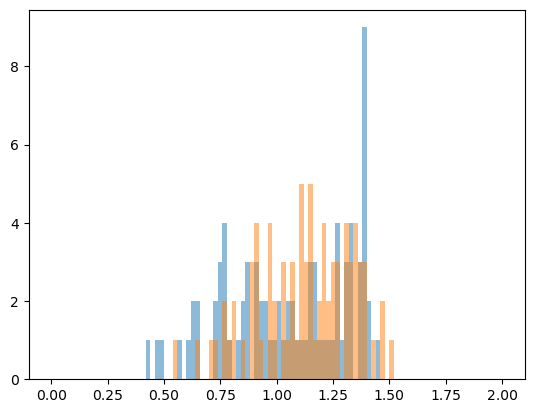

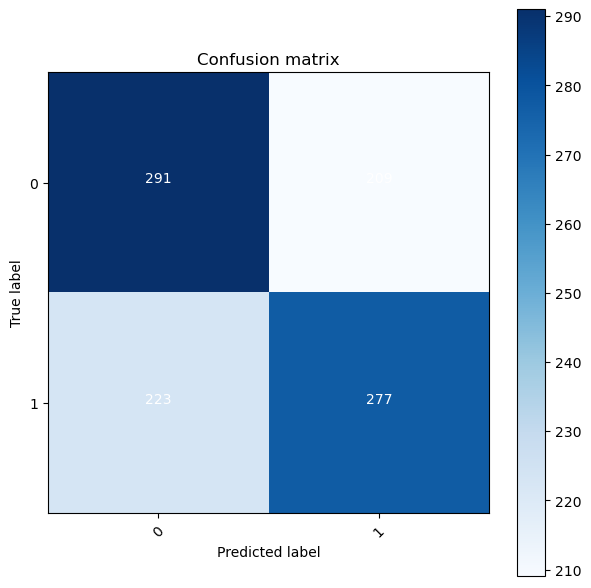

In [63]:
from facenet_pytorch import InceptionResnetV1


if pretrain:
    net = InceptionResnetV1(pretrained='vggface2', dropout_prob=dropout, device=device)
else:
    net = InceptionResnetV1(dropout_prob=dropout, device=device)


# model, optimizer, scheduler
optimizer = get_Optimizer(net, optimizer_type, lr, weight_decay) # optimizer

scheduler = get_Scheduler(optimizer, lr, scheduler_name) # scheduler

dist_threshold = evalulate(net, eval_loader1, eval_loader2, device)
test(net,test_loader,dist_threshold,device)

Using cache found in C:\Users\Fung/.cache\torch\hub\pytorch_vision_v0.6.0
100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:11<00:00,  2.67it/s]


Accuracy: 0.568
              precision    recall  f1-score   support

           0       0.54      0.91      0.68       500
           1       0.72      0.22      0.34       500

    accuracy                           0.57      1000
   macro avg       0.63      0.57      0.51      1000
weighted avg       0.63      0.57      0.51      1000

Confusion matrix, without normalization
[[457  43]
 [389 111]]


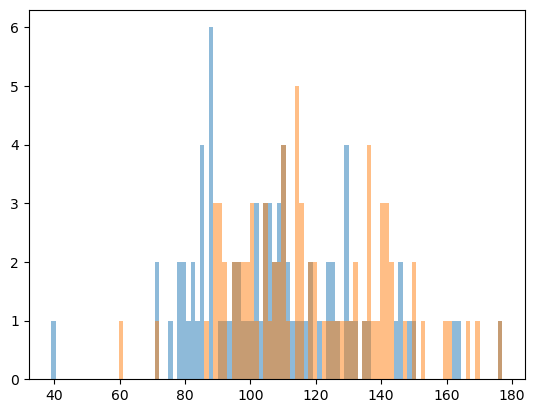

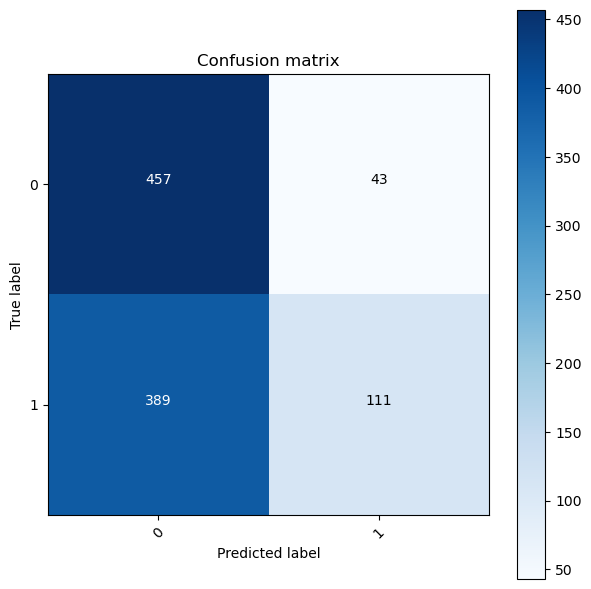

In [69]:
import torch
import torchvision

net = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)


# model, optimizer, scheduler
optimizer = get_Optimizer(net, optimizer_type, lr, weight_decay) # optimizer

scheduler = get_Scheduler(optimizer, lr, scheduler_name) # scheduler

dist_threshold = evalulate(net, eval_loader1, eval_loader2, device)
test(net,test_loader,dist_threshold,device)